# The Two-Infall Star Formation Law

## Spitoni et al. (2024)

Spitoni reports that they use a Kennicutt (1998) law:

$$ \dot\Sigma_\star(t) \propto \nu_{\rm spec} \cdot \Sigma_g(t)^k $$

where $\nu_{\rm spec} = \nu_{\rm high,low}$ is the specified star formation efficiency (SFE), 
with timescale $\tau_{\rm\star,spec} = \nu_{\rm spec}^{-1}$, and $k=1.5$.
To determine the exact scaling of this relation, I re-write their SF law as

$$ \dot\Sigma_\star(t) = F \cdot \nu_{\rm spec} \cdot \Sigma_g(t)^k $$

with unknown scaling factor $F$. In their Figure 9, they show the evolution of gas, stellar, and SFR density with time:

![image.png](Spitoni2024_fig9.png)

I read off the following values from the plot:

| Age [Gyr] | Time [Gyr] | $\Sigma_g$ [M$_\odot$ pc$^{-2}$] | $\dot\Sigma_\star$ [M$_\odot$ pc$^{-2}$ Gyr$^{-1}$] | $\tau_\star$ [Gyr] |
| --------- | ---------- | -------------------------------- | --------------------------------------------------- | ------------------ |
| 12        | 0.5        | 6                                | 10                                                  | 0.6                |
| 11        | 1.5        | 4                                | 4                                                   | 1                  |
| 9         | 3.5        | 1.5                              | 1                                                   | 1.5                |
| 6         | 6.5        | 14                               | 5                                                   | 2.8                |
| 3         | 9.5        | 12                               | 3.5                                                 | 3.4                |
| 0         | 12.5       | 8                                | 2                                                   | 4                  |

In [45]:
import pandas as pd
import numpy as np

# "data" from Spitoni et al. (2024) fig 9
plot_values = pd.DataFrame({
    'age' : [12, 11, 9, 6, 3, 0],
    'sigma_gas' : [6, 4, 1.5, 14, 12, 8],
    'sfr' : [10, 4, 1, 5, 3.5, 2]
})
plot_values.insert(1, 'time', 12.5 - plot_values['age'])
plot_values['tau_star'] = plot_values['sigma_gas'] / plot_values['sfr']
plot_values

,age,time,sigma_gas,sfr,tau_star
0,12,0.5,6.0,10.0,0.600000
1,11,1.5,4.0,4.0,1.000000
2,9,3.5,1.5,1.0,1.500000
3,6,6.5,14.0,5.0,2.800000
4,3,9.5,12.0,3.5,3.428571
5,0,12.5,8.0,2.0,4.000000


The scaling factor should be found by

$$ F = \frac{\dot\Sigma_\star(t)}{\nu_{\rm spec}(t) \cdot \Sigma_g(t)^{1.5}} $$

and its units are M$_\odot^{-1/2}$ pc.

In [120]:
def sfe_spec(time, onset=3.52):
    if time < onset:
        return 2.
    else:
        return 1.

plot_values['sfe_spec'] = plot_values['time'].apply(sfe_spec)

k = 1.5
plot_values['F'] = plot_values['sfr'] / (plot_values['sfe_spec'] * plot_values['sigma_gas']**k)
plot_values

,age,time,sigma_gas,sfr,tau_star,sfe_spec,F
0,12,0.5,6.0,10.0,0.600000,2.0,0.340207
1,11,1.5,4.0,4.0,1.000000,2.0,0.250000
2,9,3.5,1.5,1.0,1.500000,2.0,0.272166
3,6,6.5,14.0,5.0,2.800000,1.0,0.095450
4,3,9.5,12.0,3.5,3.428571,1.0,0.084197
5,0,12.5,8.0,2.0,4.000000,1.0,0.088388


Within the margin of error of my estimates from the plot, the first three values are roughly consistent with each other, as are the latter three.
But some aspect of the star formation law seems to change between the first and second infalls, which is not accounted for by the change in $\nu_{\rm spec}$.

### Weird coincidence?

The values of $\tau_\star$ that I calculated from the figure don't seem to line up very well with their stated SF law. However, they *do* seem rather similar to the molecular gas timescale.

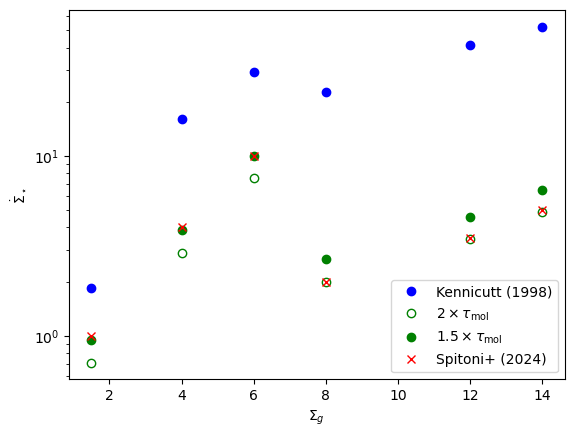

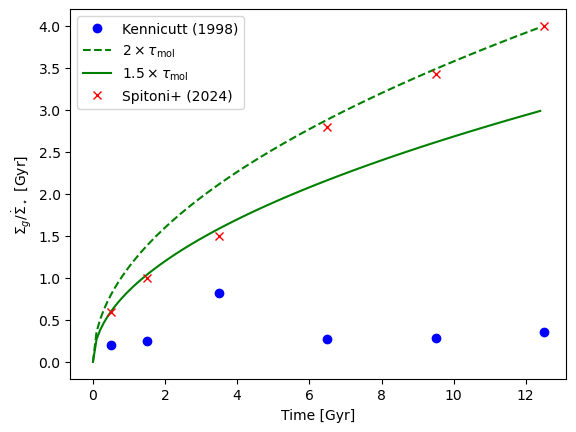

In [112]:
import matplotlib.pyplot as plt

def kennicutt_schmidt(time, sigma_gas, onset=3.5, k=1.5):
    """Predict SFR surface density from Kennicutt (1998) relation"""
    return sfe_spec(time, onset=onset) * sigma_gas**k

def molecular_timescale(time, tmol0=2, t0=12.5, exp=0.5):
    return tmol0 * (time / t0) ** exp

time_list = [0.5, 1.5, 3.5, 6.5, 9.5, 12.5]
sigma_gas_list = [6, 4, 1.5, 14, 12, 8]
sigma_star_list = [3, 9, 11, 19, 28.5, 33]
sigma_tot_list = [sigma_gas_list[i] + sigma_star_list[i] for i in range(len(time_list))]
sfr_list = [10, 4, 1, 5, 3.5, 2]
tau_star_list = [sigma_gas_list[i] / sfr_list[i] for i in range(len(time_list))]

fig, ax = plt.subplots()
ks_predict = [kennicutt_schmidt(time_list[i], sigma_gas_list[i]) for i in range(len(time_list))]
ax.plot(sigma_gas_list, ks_predict, 'bo', label='Kennicutt (1998)')
tmol_predict_mod = [sigma_gas_list[i] / (2 * molecular_timescale(time_list[i])) for i in range(len(time_list))]
ax.plot(sigma_gas_list, tmol_predict_mod, 'go', label=r'$2\times\tau_{\rm mol}$', markerfacecolor='w')
tmol_predict = [sigma_gas_list[i] / (1.5 * molecular_timescale(time_list[i])) for i in range(len(time_list))]
ax.plot(sigma_gas_list, tmol_predict, 'go', label=r'$1.5\times\tau_{\rm mol}$')
# plot data
ax.plot(sigma_gas_list, sfr_list, 'rx', label='Spitoni+ (2024)')
ax.set_xlabel(r'$\Sigma_g$')
ax.set_ylabel(r'$\dot\Sigma_\star$')
ax.set_yscale('log')
ax.legend()
plt.show()

fig, ax = plt.subplots()
tarr = np.arange(0, 12.5, 0.1)
ks_predict = [sigma_gas_list[i] / kennicutt_schmidt(time_list[i], sigma_gas_list[i]) for i in range(len(time_list))]
ax.plot(time_list, ks_predict, 'bo', label='Kennicutt (1998)')
tmol_predict_mod = [2 * molecular_timescale(t) for t in tarr]
ax.plot(tarr, tmol_predict_mod, 'g--', label=r'$2\times\tau_{\rm mol}$')
tmol_predict = [1.5 * molecular_timescale(t) for t in tarr]
ax.plot(tarr, tmol_predict, 'g-', label=r'$1.5\times\tau_{\rm mol}$')
# plot data
ax.plot(time_list, tau_star_list, 'rx', label='Spitoni+ (2024)')
ax.set_ylabel(r'$\Sigma_g / \dot\Sigma_\star$ [Gyr]')
ax.set_xlabel('Time [Gyr]')
# ax.set_yscale('log')
ax.legend()
plt.show()

$$ \dot\Sigma_\star(t) = \nu_{\rm spec}(t) \frac{1}{\tau_{\rm mol}(t)} \Sigma_g \Big(\frac{\Sigma_g(t)}{\Sigma_{g,0}}\Big)^{k-1} $$

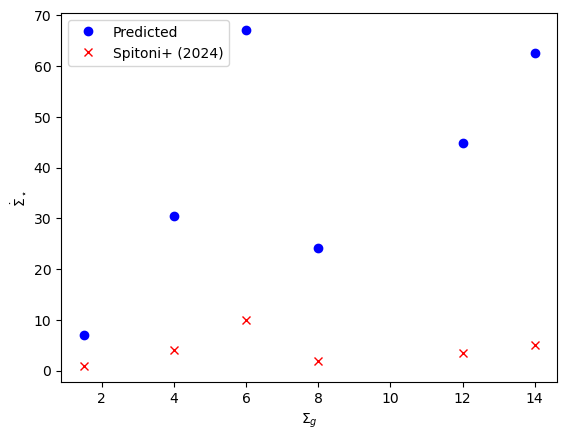

In [114]:
def sfe_spec(time, onset=3.52):
    if time < onset:
        return 2
    else:
        return 1

def sf_law(time, sigma_gas, sigma_tot, k=1.5, onset=3.52, sigma_tot_final=47):
    return sfe_spec(time, onset=onset) * (sigma_tot_final / sigma_tot) ** (k-1) * sigma_gas**k

fig, ax = plt.subplots()
sf_law_predict = [sf_law(time_list[i], sigma_gas_list[i], sigma_tot_list[i]) for i in range(len(time_list))]
ax.plot(sigma_gas_list, sf_law_predict, 'bo', label='Predicted')
# plot data
ax.plot(sigma_gas_list, sfr_list, 'rx', label='Spitoni+ (2024)')
ax.set_xlabel(r'$\Sigma_g$')
ax.set_ylabel(r'$\dot\Sigma_\star$')
# ax.set_yscale('log')
ax.legend()
plt.show()

## Calculating $M_{\rm g,Schmidt}$

In VICE, the Schmidt-Kennicutt SF law is defined as follows:

$$ \tau_\star(t) = \tau_{\rm \star, spec}(t) \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} $$

where $M_{\rm g,Schmidt}$ is the normalization of the ISM mass, and $\alpha=k-1$ converts from a gas density to a gas mass.
To convert the above equation into a format more similar to Spitoni et al. (2024), swap the masses for surface densities
and use $\tau_\star = \Sigma_g / \dot\Sigma_\star$:

\begin{align*}
    \dot\Sigma_\star &= \frac{\Sigma_g}{\tau_\star} \\
    &= \Sigma_g \nu_{\rm spec} \Big(\frac{\Sigma_g}{\Sigma_{\rm g,Schmidt}}\Big)^{k-1}
\end{align*}

where $\Sigma_{\rm g,Schmidt} = M_{\rm g,Schmidt}/A$ with area $A$. Then,

$$ \dot\Sigma_\star = \Sigma_{\rm g,Schmidt}^{1-k} \nu_{\rm spec} \Sigma_g^k  $$

which is the same form as in Spitoni et al. (2024). Therefore,

$$ F = \Sigma_{\rm g,Schmidt}^{1-k} = (M_{\rm g,Schmidt} / A)^{1-k}. $$

Rearranging the SF law gives

\begin{align*}
    \Sigma_{\rm g,Schmidt}^{1-k} &= \frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k} \\
    \implies \Sigma_{\rm g,Schmidt} &= \Big(\frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k}\Big)^{\frac{1}{1-k}} \\
    \implies M_{\rm g,Schmidt} &= A \cdot \Big(\frac{\dot\Sigma_\star}{\nu_{\rm spec} \cdot \Sigma_g^k}\Big)^{\frac{1}{1-k}} \\
    &= A \cdot F^{\frac{1}{1-k}} \\
    &= A \cdot F^{-1/\alpha}. \\
\end{align*}

Alternatively,

\begin{align*}
    \tau_\star(t) &= \tau_{\rm \star, spec}(t) \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} \\
    \implies \frac{\tau_\star}{\tau_{\rm \star,spec}} &= \Big(\frac{M_g}{M_{\rm g,Schmidt}}\Big)^{-\alpha} \\
    \implies \Big(\frac{\tau_\star}{\tau_{\rm \star,spec}}\Big)^{-1/\alpha} &= \frac{M_g}{M_{\rm g,Schmidt}} \\
    \implies M_{\rm g,Schmidt} &= M_g \Big(\frac{\tau_\star}{\tau_{\rm \star,spec}}\Big)^{1/\alpha} \\
    &= M_g (\tau_\star \cdot \nu_{\rm spec})^{1/(k-1)} \\
    &= A \cdot \Sigma_g(t) (\tau_\star \cdot \nu_{\rm spec})^{1/(k-1)} \\
\end{align*}